# References

https://github.com/lantunes/mountain-car-continuous

https://medium.com/@asteinbach/actor-critic-using-deep-rl-continuous-mountain-car-in-tensorflow-4c1fb2110f7c only used for finding the exact values of points in the env from the first figure in the site

https://gym.openai.com/docs/

https://github.com/openai/gym/blob/master/gym/envs/classic_control/continuous_mountain_car.py

# Imports

In [41]:
import gym
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

# Fuzzy Controller

In [42]:
# Fuzzy Inputs & Outputs definition
def create_fuzzy_input_output():
    x = ctrl.Antecedent(np.arange(-1.2, 0.6+0.1, 0.1), 'x')
    speed = ctrl.Antecedent(np.arange(-0.07, 0.07, 0.01), 'speed')
    action = ctrl.Consequent(np.arange(-1, 1+0.1, 0.1), 'action')
    
    names = ['VL', 'L', 'M', 'H', 'VH']
    names_x = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']
    x.automf(names = names_x)
    speed.automf(names = names)
    action.automf(names = names)

    return x, speed, action


# Define rules
def fuzzy_rules():
    x, speed, action = create_fuzzy_input_output()
    
    rules = [
        ctrl.Rule((x['X1'] | x['X2']) , action['VH']),
        ctrl.Rule((x['X3']) & (speed['L'] | speed['VL']), action['VL']),
        ctrl.Rule((x['X3']) & (speed['H'] | speed['VH']), action['VH']),
        ctrl.Rule((x['X4']) & (speed['L'] | speed['VL']), action['VL']),
        ctrl.Rule((x['X4']) & (speed['H'] | speed['VH']), action['VH']),
        ctrl.Rule((x['X5']), action['VH']),
    ]
    
    return rules


# Controller Design
def controller_design(rules):
    # Define the control system
    speeding_ctrl = ctrl.ControlSystem(rules)
    
    # Simulation object of controlsystem for representation and simulating
    speeding = ctrl.ControlSystemSimulation(speeding_ctrl)
    
    return speeding


rules = fuzzy_rules()
speeding = controller_design(rules)

# Final controller agent
def control_agent(state, agent=speeding):
    x, speed = state[0], state[1]
    
    agent.input['x'] = x
    agent.input['speed'] = speed

    agent.compute()

    return [agent.output['action']]

In [44]:
# View membership diagrams

x, speed, action = create_fuzzy_input_output()

# x.view();
# speed.view();
# action.view();
# action.universe

# Gym Env

In [45]:
env = gym.envs.make("MountainCarContinuous-v0")

MAX_EPISODES = 20
MAX_STEPS = 200

In [46]:
# Final function to render to env and take actions
def env_render(env, control_agent, MAX_STEPS=MAX_STEPS, MAX_EPISODES=MAX_EPISODES, render=True):
    
    for episode_counter in range(MAX_EPISODES):
        state = env.reset()
        total_rewards = 0
        rewards = []
        done = False

        for step_counter in range(MAX_STEPS):

            if render:
                env.render()
            action = control_agent(state)
            next_state, reward, done, _ = env.step(action)
#             print(reward)
#             print(next_state)
            total_rewards += reward
            rewards.append(reward)

            state = next_state
            if done:
                break
                
        print("episode number:{}, total_reward:{:.2f}, step_counter:{}".format(episode_counter, total_rewards, step_counter))
                
        if done:
            env.close()
            break
            
    env.close()
    return rewards, total_rewards

In [47]:
rewards, total_rewards = env_render(env, control_agent, MAX_STEPS=MAX_STEPS, MAX_EPISODES=MAX_EPISODES, render=True)

episode number:0, total_reward:93.52, step_counter:109


# Plot rewards

In [48]:
# plot rewatds
def plot_rewards(rewards, limit=False, bottom=-3, top=8, ylabel="Rewards of steps"):
    plt.figure(figsize=(15, 8))
    xticks = len(rewards)
            
    plt.plot(range(1,xticks+1), rewards)
    if limit:
        plt.ylim(top=top)
        plt.ylim(bottom=bottom)
            
    plt.xlabel("Steps")
    plt.ylabel(ylabel)

    plt.show()

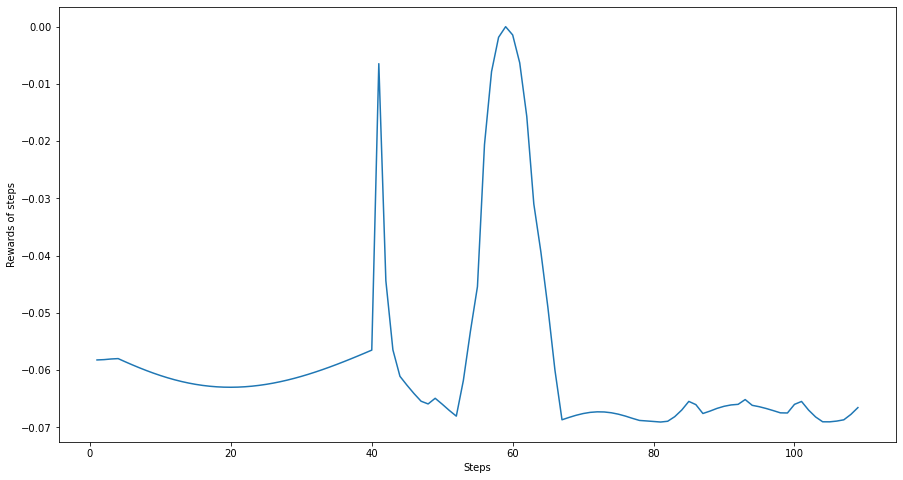

In [49]:
# Without final reward
plot_rewards(rewards[:-1])

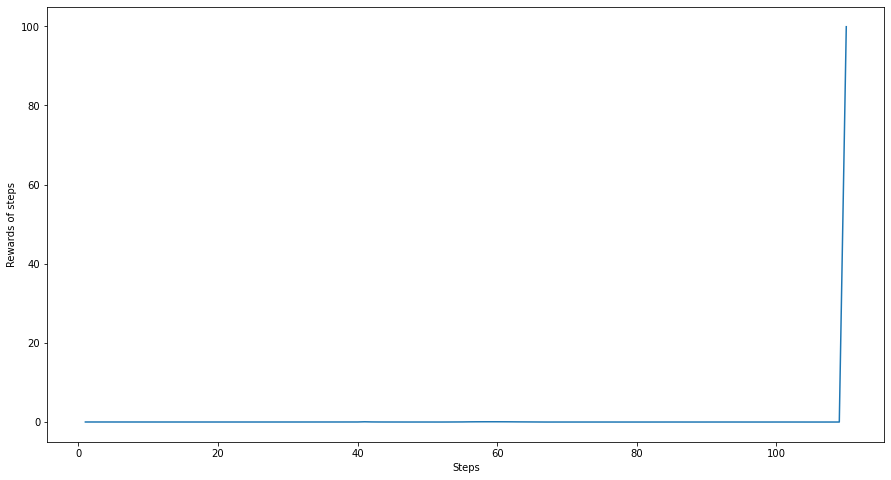

In [50]:
# With final reward
plot_rewards(rewards)

In [51]:
# total_rewards value
total_rewards

93.52344311869287